# Introduction to Deep Learning

## Hands-on 3a: Reinforcement Learning with Policy Gradient
Giuseppe Carleo and Filippo Vicentini

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/21como-intro-to-deeplearning/3b-policy-gradient-harder.ipynb) 

### Link to the GitHub repository:
https://github.com/PhilipVinc/IntroDeepLearning   or  https://bit.ly/3ki90ki

## Intro

This is a followup to notebook 3a (policy gradient). It reproduces the same problem but uses a variable map and try to train a policy to solve different environments.

In [1]:
#!pip install gym coax jax haiku flax optax matplotlib pygame

In [1]:
# Import all things
import gym               # defines the problem
import coax              # easy to use policy gradient learning
import jax               # 
import jax.numpy as jnp  #
import haiku as hk       # easy to define neural networks
import optax             # optimisers
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# First, we define the problem
env = gym.make('FrozenLake-v1')

In [3]:
# We can initialise a 'trajectory', or the 'state' of the system 
env.reset()
# And then we can 'render' the current state with fancy graphics.
env.render()

In [4]:
# By the way, we will later see that it's possible to generate other maps
import gym

from gym.envs.toy_text.frozen_lake import generate_random_map

# size is the edge of the map, p is the probability to have ice (so $1-p$ is probability to have an hole)
random_map = generate_random_map(size=4, p=0.8)

# Then we provide the map object to the environemnt
env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=False) # creating the FrozenLake environment
env.reset()                     # reseting the environment to its initial state
env.render()                    # prints the environment state to the standard output

In [8]:
def val(x):
    if x == 'H':
        return -1
    elif x == 'G':
        return 1
    else:
        return 0
data = [[val(tile) for tile in line] for line in random_map]
tile_data = np.array(data).flatten()
print(tile_data)

[ 0 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  1]


In [9]:
def map_state_values(desc):
    data = [[val(tile) for tile in line] for line in random_map]
    tile_data = jnp.array(data).flatten()
    return tile_data

However, how do we store in memory the data representing the position of the elf, that of the target, and how do we encode our possible actions so that we can create a mathematical model of the problem?

### Observation Space

The observation is a value representing the agent's current position as `current_row * nrows + current_col` (where both the row and col start at 0).
For example, the goal position in the $4\times4$ map can be calculated as follows: $3 \cdot 4 + 3 = 15$.
The number of possible observations is dependent on the size of the map.
For example, the $4\times 4$ map has 16 possible observations.

In mathematical terms, 
$$ s_t \in [0,15]$$

In [42]:
print("The observation state is: ", env.observation_space)

The observation state is:  Discrete(16)


In [43]:
print("And a random cofiguration will be: ", env.observation_space.sample())

And a random cofiguration will be:  3


### Action Space
The agent takes a 1-element vector (aka, a scalar) for actions.
The action space is `(dir)`, where `dir` decides direction to move in which can be:
- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

In mathematical terms, 
$$ a_t \in [0,3]$$

In [44]:
print("The action space is: ", env.action_space)

The action space is:  Discrete(4)


### Reward

Reward schedule $r_t(s_t)$:
- Reach goal(G): +1
- Reach hole(H): 0
- Reach frozen(F): 0

Note that the rewards for a succesful run will therefore be $r_0 = 0$, $r_1=0$ ... $r_T = 1$, so any succesful run will have
$$
R = \sum_{t=0}^T r_t = 1,
$$
because we're giving a reward only when we hit the goa.

This means that the reward for solving the puzzle in the smallest amount of moves, or infinitely main moves, is the same. To bias the policy to solve in fewer moves the puzzle, we can add some negative reward at every step.

## Defining the policy

We want to define the policy $ pi(a | s_t) $ that gives the probability of each move $a={0,1,2,3}$ given a current state configuration $s_t$.

To have a simpler implentation we will define $\pi : {0,1\dots 15} \rightarrow \mathbb{R}^4 $, which will return the unnormalized log-probability of every action. 

In [10]:
def π_fun(S, is_training):
    map_values = hk.get_state("map", shape=S.shape, dtype=jnp.int32, init=jnp.zeros)
    map_values = map_values.reshape(S.shape)
    
    state_and_map = jnp.hstack([map_values, S])
    logits = hk.Linear(env.action_space.n, w_init=jnp.zeros)
    
    return {'logits': logits(state_and_map)}

We can investigate how that works...

In [11]:
# For example, this gives us
forward = hk.transform_with_state(π_fun)
pars, state = forward.init(jax.random.PRNGKey(1), jax.numpy.zeros(16), True)
forward.apply(pars, state, jax.random.PRNGKey(1), jax.numpy.zeros(16), True)

({'logits': DeviceArray([0., 0., 0., 0.], dtype=float32)},
 {'~': {'map': DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}})

### Using Coax

In principle we'd have to sample from the log-distribution above at every time $t$ to determine a trajectory ${s_1, a_1, s_2, a_2...}$, and we'd have to define the REINFORCE/Policy gradient algorithm ourselves.

However, it turns out that somebody already did the hard work for ourselves. See for example https://coax.readthedocs.io/ so we're going to use this package going forward.

We can create a Policy from the function `π_fun` and the environment description/state.
THis is an object that encapsulates the current parameters of the policy, as well as the current state of the environment. 
It exposes a few useful functions such as:
 - `Policy.sample`, which samples a possible configuration given the state the environment is in
 - `Policy.update`, which updates the weights according to the REINFORCE gradient update

In [12]:
# First we wrap the environment into a training monitor wrapper, so we can automatically log at every step some information
env = coax.wrappers.TrainMonitor(env)

In [13]:
# We create the Policy funciton
pi = coax.Policy(π_fun, env)

In [14]:
# For example, what move can we have if we are in 0?
actions = [pi(0) for i in range(1000)]

log probabilities:  {'logits': DeviceArray([0., 0., 0., 0.], dtype=float32)}


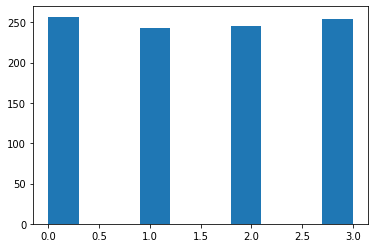

In [15]:
print("log probabilities: ", pi.dist_params(0))
plt.hist(actions);

This is consistent with the fact that our initialisation of the weights is all 0s.

In [20]:
pi.function_state['~']['map'] = map_state_values(env.desc)

### Reward tracing 

We create a reward tracing object, which collects at every time $t$ the reward $r_t$ and eventually discounts it by a factor $\gamma$ so that

$$ R = \sum_{t=0}^T \gamma^t r_t $$

This is basically a smarter version of a list, that we will use later. Using a $\gamma < 1$ allows us to give higher rewards to shorter trajectories.

In [23]:
# experience tracer
tracer = coax.reward_tracing.MonteCarlo(gamma=0.9)

### Policy Gradient objective

Coax has several objects functions used to train RL algorithms.
`VanillaPG` is a A vanilla policy-gradient objective, a.k.a. REINFORCE-style objective.
$$J(\theta; s,a)\ =\ \mathcal{A}(s,a)\,\log\pi_\theta(a|s)$$


In [24]:
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optax.adam(0.01))

### Writing down the 'RL' loop

In [102]:
# First we reset the environment so we get the initial state
s_t = env.reset()
print(s_t)

0


In [103]:
a_t = pi(s_t)
print(f"action a_t = {a_t}")

action a_t = 3


In [104]:
s_tnext, r_t, is_done, info = env.step(a_t)
print(f"s_tnext: {s_tnext}, r_t:{r_t}, is_done:{is_done}, info:{info}")

s_tnext: 0, r_t:0.0, is_done:False, info:{'prob': 1.0, 'monitor': {'T': 1, 'ep': 1}}


In [105]:
# We add to the reward tracer this last step
tracer.add(s_t, a_t, r_t, is_done)

In [106]:
# And now, we repeat many times:
tracer.reset()
s_t = env.reset()
for t in range(env.spec.max_episode_steps):
    a_t = pi(s_t)
    s_tnext, r_t, is_done, info = env.step(a_t)
    tracer.add(s_t, a_t, r_t, is_done)
    env.render()
    
    if is_done:
        break

In [107]:
# and we then update the weights according to this
while tracer:
    transition_batch = tracer.pop()
    vanilla_pg.update(transition_batch, Adv=transition_batch.Rn)

In [108]:
#vanilla_pg.pi.params

In [109]:
## Finally, we do this many times
pi = coax.Policy(π_fun, env)
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optax.adam(0.01))
tracer.reset()

In [ ]:
# You see that this did not work well. It's because there is no signal at the beginning as the reward is always 0!
# Let's try to set the reward to non zero. For example, let's make him not take the useless moves such as up when he's at the top already.

pi = coax.Policy(π_fun, env)
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optax.adam(0.01))
tracer.reset()

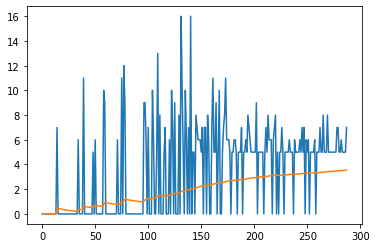

In [ ]:
plt.plot(Rvals*Tsteps)
plt.plot(jnp.cumsum(Rvals*Tsteps)/jnp.arange(Rvals.size))

(0, 1)

In [33]:
# You see that this did not work well again because he is not learning to get to the objective, and keeps falling on the holes.
# Let's give him a penalty if he falls on the holes

pi = coax.Policy(π_fun, env)
vanilla_pg = coax.policy_objectives.VanillaPG(pi, optimizer=optax.adam(0.01))
tracer.reset()

In [35]:
# train
Rvals = []
Tsteps = []

for ep in range(500):
    random_map = generate_random_map(size=4, p=0.8)
    env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=False) # creating the FrozenLake environment
    env = coax.wrappers.TrainMonitor(env)
    pi.function_state['~']['map'] = map_state_values(env.desc)

    do_render = ep % 50 == 0

    for rep in range(2):
        s_t = env.reset()
        if do_render:
            env.render()

        for t in range(env.spec.max_episode_steps):
            a_t = pi(s_t)
            s_tnext, r_t, is_done, info = env.step(a_t)

            if jnp.array_equal(s_tnext, s_t):
                r_t = r_t - 0.01
            if is_done and s_tnext != 15:
                r_t = r_t - 0.05
                
            xpos, ypos = divmod(s_tnext, 4)
            distance = jnp.sqrt((xpos-3)**2 + (ypos-3)**2)
            if not is_done:
                r_t = r_t + 0.02/distance
            
            # update
            tracer.add(s_t, a_t, r_t, is_done)

            while tracer:
                transition_batch = tracer.pop()
                vanilla_pg.update(transition_batch, Adv=transition_batch.Rn)

            if do_render:
                env.render()

            if is_done:
                Rvals.append(env.G)
                Tsteps.append(t)
                #print(vanilla_pg.pi.params)
                break

            s_t = s_tnext

        # early stopping
        if env.avg_G > env.spec.reward_threshold:
            break
        
Rvals = jnp.array(Rvals)
Tsteps = jnp.array(Tsteps)

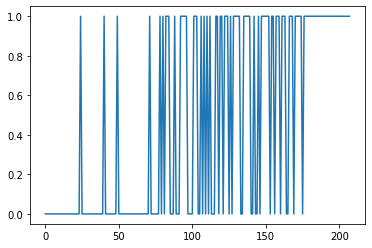

In [147]:
plt.plot(Rvals)